## This laboratory will be conducted over two sessions
## You are expected to finish the software and test the code in simulation between the sessions! ##

# Manipulating objects

For this laboratory, we will use two robots distant from each other of 25cm as depicted in the figure below

<img src="./2_robot_config.png" width="500">

There is 1cm between the end-effector "shell" and the position of the frame as depicted in the figure below

<img src="./foot_close.png" width="300">

<img src="./box.jpg" width="200">

The objects to grasp are soft cubes with a 5cm side.
Three cubes are stacked on top of each other. The goal of the laboratory is to design a controller to will move the two cubes on the top away
and pick the bottom cube and lift it up by 10cm.

In [18]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)

# we import useful libraries
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from time import sleep, time
import copy

# this function returns the body Jacobian
from robot_utils import getBodyJacobianOrientedLikeSpatialFrame

# we import the robot class
use_real_robot = True

if use_real_robot:
    from NYUFinger.real import NYUDualFingerHardware as Robot   
else:
    from NYUFinger.sim import NYUDualFingerSimulator as Robot


# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

## Instantiate The Robots
If you're using the real robots, put them into zero position and then run the next cell to instantiate and reset them. 

In [19]:
robot = Robot()

In [32]:
if use_real_robot:
    robot.reset_sensors()
else:
    robot.reset()

Successfully reset the sensor values to: [0. 0. 0.]
Successfully reset the sensor values to: [0. 0. 0.]


You can also visualize the robot to ensure that the real movement of the robot matches the 3D simulator environment (Only if you're using the real robot)

In [21]:
if use_real_robot:
    from NYUFinger.utils.vis import NYUDualFingerVisualizer
    vis = NYUDualFingerVisualizer()
    start_time = time()
    while time()-start_time < 60:
        q, dq = robot.get_state()
        robot.send_joint_torque(np.zeros(6))
        vis.show(q)
        sleep(0.01)
else:
    print('This visualization is meaningless for the simulated robot experiment')

KeyboardInterrupt: 

## Interacting with the Robot
For this lab, you'll be using two robots at the same time. Unlike the previous labs where the $\tau$, $q$, and $dq$ were 3D vectors, in this lab robot takes 6D commands and returns 6D states. The first three numbers are for finger 1 (left) and the last three are for the finger 2 (right). Let's make sure you can read the sates and command the robot:

In [27]:
q, dq = robot.get_state()
q1 = q[:3]
q2 = q[3:]
dq1 = dq[:3]
dq2 = dq[3:]
print(f'Robot1: q={q1}, dq1={dq1}')
print(f'Robot2: q={q2}, dq1={dq2}')

Robot1: q=[  0.06890468  -0.13557754 -17.92814655], dq1=[-0.00568141 -0.1136282  -0.05113269]
Robot2: q=[-0.00120458 -0.00050721 -0.00110001], dq1=[-0.01136282  0.07953975  2.27256415]


If you're using the simulator, you can also access the ground truth posiion of the cubes using `robot.get_cube_positions()` and reset their location using `robot.reset()`: 

In [ ]:
if not use_real_robot:
    robot.reset()
    print(robot.get_cube_positions())

{'cube1': array([ 0.125     , -0.05      ,  0.02496428]), 'cube2': array([ 0.125    , -0.05     ,  0.0749457]), 'cube3': array([ 0.125     , -0.05      ,  0.12493277])}


## Questions
In this laboratory you are expected to re-use code from the previous laboratories (e.g. to plot, compute forward kinematics, etc) and solve the problem in both simulation and using the real robot. For both simulation and real robot deployment, you're expected to upload a short video of the robot solving the task alongside the report containing plots showing the robot reaching the desired 10cm goal for the designated cube.

1. Using an impedance controller (Lab4 - use the ``getBodyJacobianOrientedLikeSpatialFrame`` function to get the Jacobian) and one trajectory generation method seen in Lab3 write a complete controller that solves the problem: move the top two cubes away, grasp the last cube and move it up by 10cm. In the report, describe in details the controller you designed (what it does, etc) and the results you obtained.

2. Test your controller in simulation. Save and plot the results.
   
3. Test the controller on the real robots. Save and plot the results.

4. (optional - bonus) Extend the controller to rearrange the cubes - putting the bottom one on top of the two others.

In [29]:
### COPY PASTE YOUR FORWARD KINEMATICS FUNCTION HERE FROM LAB 2 (and other helper functions)
def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[:3, 3] = vector
    
    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[1:3, 1:3] = [[cos, -sin], [sin, cos]]
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:3:2,0:3:2] = [[cos, sin], [-sin, cos]]
    
    ### we return the object
    return transform


def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:2,0:2] = [[cos, -sin], [sin, cos]]
    
    ### we return the object
    return transform


def forward_kinematics_1(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    l3 = 0.014
    ###WRITE YOUR CODE HERE
    SH1=translate([l0, 0,0])@ rotateX(theta[0])
    H1H2= translate([0, 0, l3]) @ rotateZ(theta[1])
    H2K = translate([0, -l1, 0]) @ rotateZ(theta[2])
    KF = translate([0, -l2, 0])
    T_SH1=SH1
    T_SH2 = T_SH1 @ H1H2
    T_SK = T_SH2 @ H2K
    T_SF = T_SK @ KF
    ### we return the object
    return T_SF

In [30]:
def forward_kinematics_2(q):
    T = forward_kinematics_1(q)
    T[0, 3] -= 0.25
    return T


In [33]:
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    T = t_goal - t_init
    t_diff = t - t_init
    desired_position = position_init + (10*(t_diff/T)**3 - 15*(t_diff/T)**4+6*(t_diff/T)**5) * (position_goal-position_init)
    desired_velocity = (30*(t_diff**2)/(T**3) - 60*(t_diff**3)/(T**4) + 30*(t_diff**4)/(T**5)) * (position_goal-position_init)
    # we return the answer
    return desired_position, desired_velocity

In [54]:
q = robot.get_state()[0]
pos1 = forward_kinematics_1(q[:3])[:3, 3:].squeeze()
pos2 = forward_kinematics_2(q[3:])[:3, 3:].squeeze()
print("Position of robot 1:", list(np.round(pos1, 4)), sep="\n")
print("Position of robot 2:", list(np.round(pos2, 4)), sep="\n")
averge = ((pos1+pos2)/2).squeeze()
print("Average of the positions:", list(averge), sep="\n")

Position of robot 1:
[np.float64(0.3102), np.float64(-0.187), np.float64(-0.2597)]
Position of robot 2:
[np.float64(0.0914), np.float64(-0.3138), np.float64(-0.0477)]
Average of the positions:
[np.float64(0.2007682929194041), np.float64(-0.2504189981215316), np.float64(-0.15370832974996465)]


In [ ]:
positions_1 = {"above_cube": np.array([np.float64(0.3338), np.float64(-0.1495), np.float64(-0.2812)]), 
               "claw_cube3": np.array([np.float64(0.2639), np.float64(-0.161), np.float64(-0.0507)]),
               "cube3": np.array([np.float64(0.2068), np.float64(-0.1705), np.float64(-0.0363)])
               }
positions_2 = {"above_cube": np.array([np.float64(0.0387), np.float64(-0.1467), np.float64(-0.2842)]),
               "claw_cube3": np.array([np.float64(0.108), np.float64(-0.1759), np.float64(-0.0653)]),
               "cube3": np.array([np.float64(0.15), np.float64(-0.1721), np.float64(-0.0424)])
               }
if not use_real_robot:
    robot.reset()
    cube_positions = copy.deepcopy(robot.get_cube_positions())
    for cube in cube_positions:
        cube_positions[cube][2] = -cube_positions[cube][2]
    print(cube_positions)


# steps for the robot to follow
t_goals = [5, 5, 5]
t_start = time()
steps = ["above_cube", "claw_cube3", "cube3"]
step = 0

run_time = sum(t_goals)
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
P = np.array([1000, 1000, 100])
D = np.array([0.1, 0.1, 0.1])


## we allocate a few vectors to collect data while we do the simulation
# we keep track of time
time0 = np.zeros([num_steps])
# we will store the sensor values (angular position and velocities)

measured_positions_f1 = np.zeros([num_steps,3])
measured_velocities_f1 = np.zeros_like(measured_positions_f1)

measured_positions_f2 = np.zeros_like(measured_positions_f1)
measured_velocities_f2 = np.zeros_like(measured_positions_f1)

# we will store the end effector position (desired and measured)

measured_finger_position_f1 = np.zeros([num_steps,3])
desired_finger_position_f1 = np.zeros([num_steps,3])

measured_finger_position_f2 = np.zeros([num_steps,3])
desired_finger_position_f2 = np.zeros([num_steps,3])

# we will store the end effector velocitu (desired and measured)

measured_finger_velocity_f1 = np.zeros([num_steps,3])
desired_finger_velocity_f1 = np.zeros([num_steps,3])

measured_finger_velocity_f2 = np.zeros([num_steps,3])
desired_finger_velocity_f2 = np.zeros([num_steps,3])


q0, dq0 = robot.get_state()
q0_1 = q0[:3]
q0_2 = q0[3:]

p_prev_1 = forward_kinematics_1(q0_1)[0:3, 3]
p_prev_2 = forward_kinematics_2(q0_2)[0:3, 3]
t_prev = 0


for i in range(num_steps):
    # get the current time and save it
    time0[i] = dt * i

    # we get the position and velocities of the joints
    q, dq = robot.get_state()
    q1 = q[:3]
    q2 = q[3:]
    dq1 = dq[:3]
    dq2 = dq[3:]

    # Determine current goal
    goal_time = 0
    init_step = step
    for j in range(len(t_goals)):
        goal_time += t_goals[j]
        if time0[i] >= goal_time:
            step = j+1
        else:
            break
    
    if step!= init_step:
        t_prev = time0[i]
        p_prev_1 = forward_kinematics_1(q1)[0:3, 3]
        p_prev_2 = forward_kinematics_2(q2)[0:3, 3]

    goal_1 = positions_1[steps[step]]
    goal_2 = positions_2[steps[step]]


    pose_1 = forward_kinematics_1(q1)
    measured_finger_position_f1[i,:] = pose_1[0:3,3]
    p_measured_1 = measured_finger_position_f1[i]

    pose_2 = forward_kinematics_2(q2)
    measured_finger_position_f2[i,:] = pose_2[0:3,3]
    p_measured_2 = measured_finger_position_f2[i]
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER (robot 1)
    J1 = getBodyJacobianOrientedLikeSpatialFrame(q1)
    p_ref_1, v_ref_1 = compute_trajectory(p_prev_1, goal_1, t_prev, goal_time, time0[i])
    # if (dt*(i+1)%t_goals[0] ==0 ):
    #     print("Time: ", time0[i])
    #     print("Cube position:", cube_positions["cube3"])
    #     print("Desired position", p_ref_1)
    p_diff_1 = p_ref_1 - p_measured_1

    p_measured_1_dot = J1 @ dq1
    d_diff_1 = v_ref_1 - p_measured_1_dot

    measured_velocities_f1[i,:] = dq1
    measured_finger_velocity_f1[i,:] = p_measured_1_dot
    desired_finger_velocity_f1[i, :] = v_ref_1
    desired_finger_position_f1[i, :] = p_ref_1

    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER (robot 2)
    J2 = getBodyJacobianOrientedLikeSpatialFrame(q2)
    p_ref_2, v_ref_2 = compute_trajectory(p_prev_2, goal_2, t_prev, goal_time, time0[i])
    p_diff_2 = p_ref_2 - p_measured_2

    p_measured_2_dot = J2 @ dq2
    d_diff_2 = v_ref_2 - p_measured_2_dot

    measured_velocities_f2[i,:] = dq2
    measured_finger_velocity_f2[i, :] = p_measured_2_dot
    desired_finger_velocity_f2[i, :] = v_ref_2
    desired_finger_position_f2[i, :] = p_ref_2

    #joint torques

    joint_torques1 = J1.T @ ((np.diag(P) @ p_diff_1) + (np.diag(D) @ d_diff_1))
    joint_torques1 = np.expand_dims(joint_torques1, axis=1)

    joint_torques2 = J2.T @ ((np.diag(P) @ p_diff_2) + (np.diag(D) @ d_diff_2))
    joint_torques2 = np.expand_dims(joint_torques2, axis=1)


    joint_torques = np.vstack([joint_torques1, joint_torques2]).squeeze()

    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    sleep(max(dt*(i+1) - (time()-t_start), 0))

KeyboardInterrupt: 

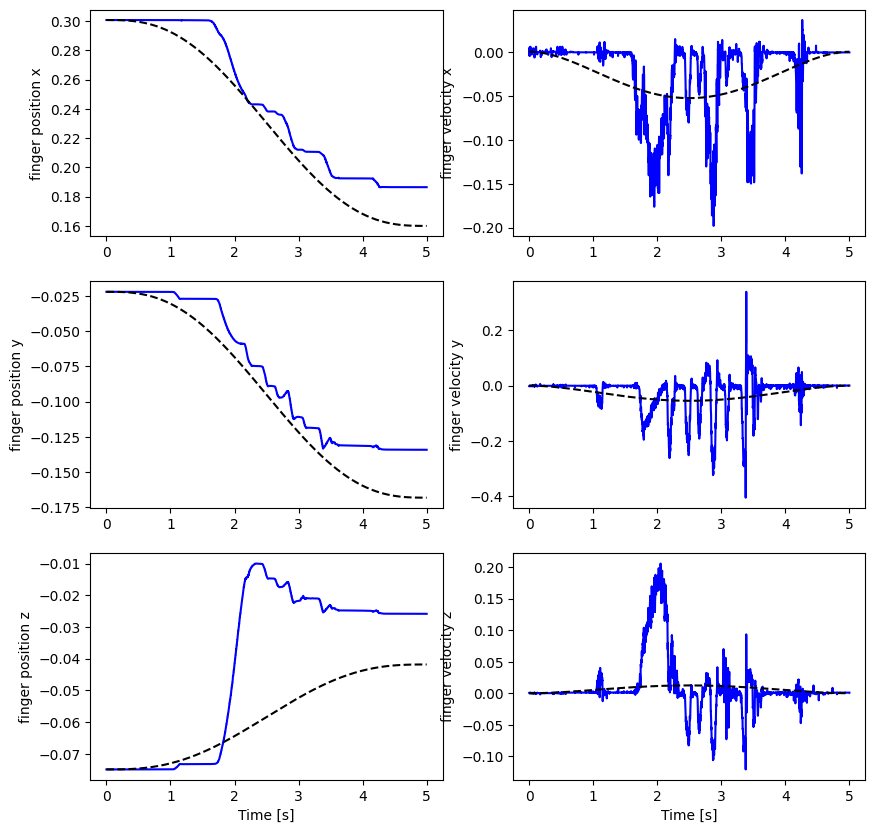

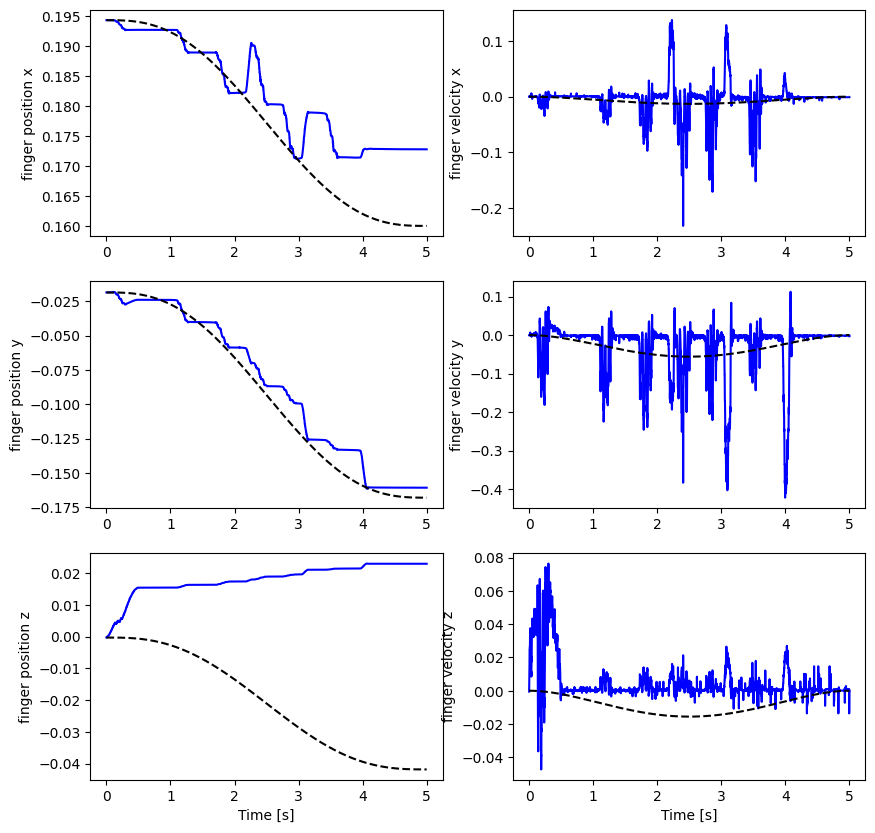

In [43]:
#robot 1 and robot 2
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'finger position x')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'finger position y')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'finger position z')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'finger velocity x')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'finger velocity y')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'finger velocity z')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time0, measured_finger_position_f1, desired_finger_position_f1, measured_finger_velocity_f1,desired_finger_velocity_f1)
plot_joint_posvel(time0, measured_finger_position_f2, desired_finger_position_f2, measured_finger_velocity_f2, desired_finger_velocity_f2)